In [1]:
%pylab inline
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cmocean.cm as cmo
from matplotlib.patches import Polygon
import gsw
from glob import glob

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/Users/erik/Desktop/'
degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Figures/Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

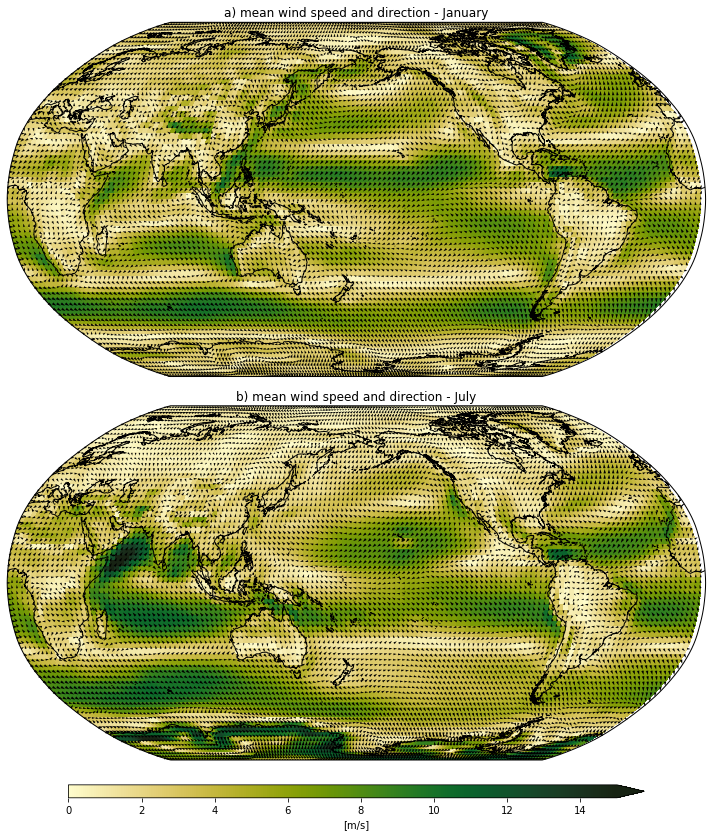

In [3]:
fignum = '03_03'

U = xr.open_dataset(datadir+'NCEP/uwnd.mon.mean.nc').uwnd.groupby("time.month").mean('time')
V = xr.open_dataset(datadir+'NCEP/vwnd.mon.mean.nc').vwnd.groupby("time.month").mean('time')
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
gs = gridspec.GridSpec(3, 1, height_ratios=[6, 6, 1]) 

months = [1, 7]
for i in range(2):
    ai = fig.add_subplot(gs[i], projection=projection)
    ai.coastlines(resolution='50m')
    a = ai.pcolormesh(spd.lon, spd.lat, spd.sel(month=months[i]), vmin=0, vmax=15,
                      cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(month=months[i]).values, V.sel(month=months[i]).values,
              transform=cartopy.crs.PlateCarree())
    ai.set_title('%s) mean wind speed and direction - %s' %(chr(ord('a') + i), datetime.date(1900, months[i], 1).strftime('%B')))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

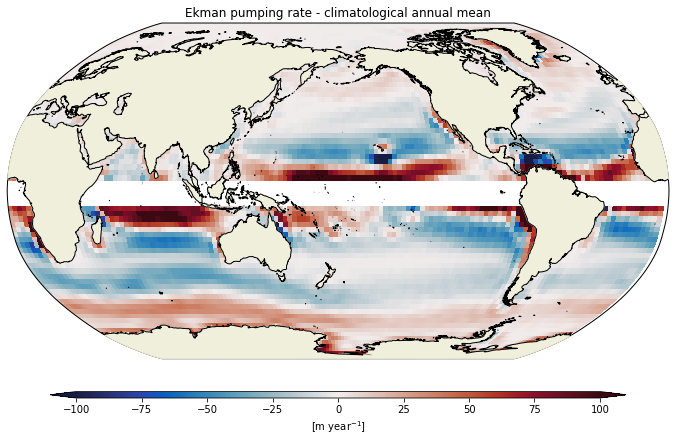

In [4]:
fignum = '03_08'

U = xr.open_dataset(datadir+'NCEP/uwnd.mon.mean.nc').uwnd.mean('time')
V = xr.open_dataset(datadir+'NCEP/vwnd.mon.mean.nc').vwnd.mean('time')
spd = np.hypot(U, V)
rho_air = 1.3
Cd = 1e-3*(0.61 + (0.063*spd))
taux = rho_air * Cd * U * spd
tauy = rho_air * Cd * V * spd

We = np.nan * np.ones(taux.shape)
for j in range(1, We.shape[0]-1):
    if abs(taux.lat[j]) > 5:
        for i in range(We.shape[1]):
            ip1 = i+1 if i < We.shape[1]-1 else 0
            im1 = i-1 if i >0 else We.shape[1]-1
            dtxdy = (taux[j+1, i] - taux[j-1, i]) / ((taux.lat[j+1] - taux.lat[j-1]) * 1852 * 60)
            dtydx = (tauy[j, ip1] - tauy[j, im1]) / ((taux.lon[ip1] - taux.lon[im1]) * 1852 * 60 * np.cos(taux.lat[j]/180*np.pi))
            We[j, i] = 1/(1020 * gsw.f(taux.lat[j])) * (dtydx - dtxdy) * 86400*365

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(resolution='50m', zorder=11)
ax.add_feature(cartopy.feature.LAND, zorder=10)

a = ax.pcolormesh(taux.lon, taux.lat, We, cmap=cmo.balance, vmin=-100, vmax=100,
                  transform=cartopy.crs.PlateCarree(), rasterized=True)

plt.title('Ekman pumping rate - climatological annual mean')
cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m year$^{-1}$]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

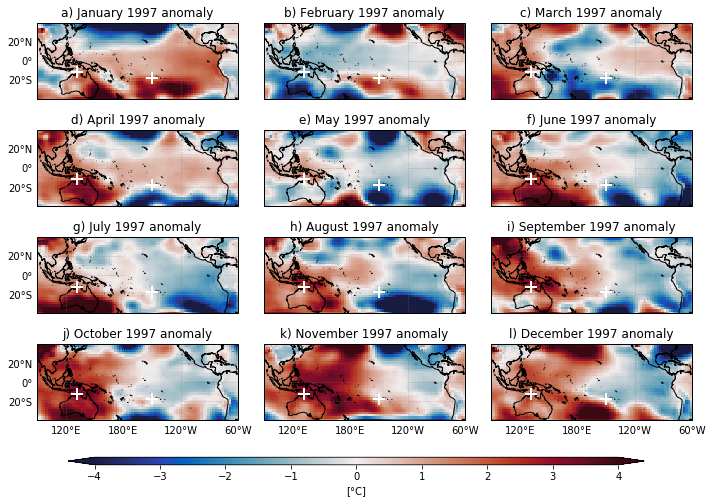

In [5]:
fignum = '06_25'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lon=slice(90, 300), lat=slice(40, -40))

climatology = P.groupby("time.month").mean("time")
anomalies = P.groupby("time.month") - climatology

projection = cartopy.crs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        i = row*3 + col
        p = anomalies.sel(time='1997-%.2d-01' % (i+1))
        a = p.plot(cmap=cmo.balance, vmin=-4, vmax=4,
                   transform=cartopy.crs.PlateCarree(), 
                   ax=ai, add_colorbar=False, rasterized=True)
        ai.plot([-150, 131], [-18, -12], 'w+', markersize=12, markeredgewidth=2, transform=cartopy.crs.PlateCarree())
        ai.set_title('%s) %s anomaly' % (chr(ord('a') + i), p.time.dt.strftime('%B %Y').values))
        ai.set_extent([90, 300, -40, 40], crs=cartopy.crs.PlateCarree())

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([-120, -60, 120, 180])
        gl.ylocator = mticker.FixedLocator([-40, -20, 0, 20, 40])
        if row == 3:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym, use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

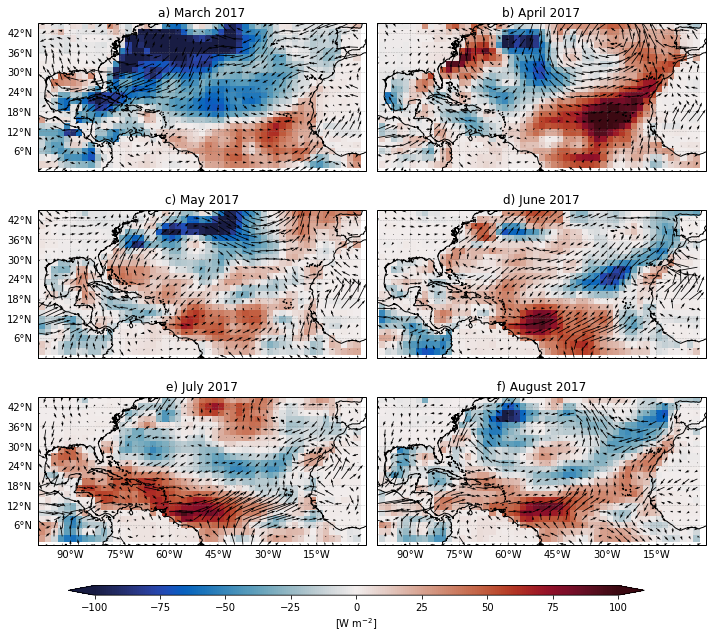

In [6]:
fignum = '06_31'

NSWRS = xr.open_mfdataset(datadir+'NCEP/nswrs.*', combine='by_coords').nswrs.sel(lon=slice(260, 360), lat=slice(45, 0))
NLWRS = xr.open_mfdataset(datadir+'NCEP/nlwrs.*', combine='by_coords').nlwrs.sel(lon=slice(260, 360), lat=slice(45, 0))
SHTFL = xr.open_mfdataset(datadir+'NCEP/shtfl.*', combine='by_coords').shtfl.sel(lon=slice(260, 360), lat=slice(45, 0))
LHTFL = xr.open_mfdataset(datadir+'NCEP/lhtfl.*', combine='by_coords').lhtfl.sel(lon=slice(260, 360), lat=slice(45, 0))

Net = -(NSWRS + NLWRS + SHTFL + LHTFL)

climatology = Net.groupby("time.month").mean("time")

U = xr.open_dataset(datadir+'NCEP/uwnd.mon.mean.nc').uwnd.sel(lon=slice(260, 360), lat=slice(45, 0))
V = xr.open_dataset(datadir+'NCEP/vwnd.mon.mean.nc').vwnd.sel(lon=slice(260, 360), lat=slice(45, 0))
uclim = U.groupby("time.month").mean('time')
vclim = V.groupby("time.month").mean('time')
X, Y = np.meshgrid(U.lon, V.lat)

projection = cartopy.crs.PlateCarree(central_longitude=-50)
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
hr = 3
gs = gridspec.GridSpec(4, 2, height_ratios=[hr, hr, hr, 1]) 

for i, mon in enumerate([3, 4, 5, 6, 7, 8]):
    ai = fig.add_subplot(gs[i//2, i%2], projection=projection)
    ai.coastlines(resolution='50m')
    ai.set_extent([-100, 0, 0, 45], crs=cartopy.crs.PlateCarree())
    ai.set_title('%s) %s' % (chr(ord('a') + i), datetime.date(2017, mon, 1).strftime('%B %Y')))

    anom = Net.sel(time=slice('2017-%d-01' %mon, '2017-%d-01' %(mon+1))).mean('time') - climatology.sel(month=mon)
    a = ai.pcolormesh(anom.lon, anom.lat, anom, cmap=cmo.balance, vmin=-100, vmax=100,
                      transform=cartopy.crs.PlateCarree(), rasterized=True)
    
    ua = U.sel(time=slice('2017-%d-01' %mon, '2017-%d-01' %(mon+1))).mean('time') - uclim.sel(month=mon)
    va = V.sel(time=slice('2017-%d-01' %mon, '2017-%d-01' %(mon+1))).mean('time') - vclim.sel(month=mon)
    ai.quiver(X, Y, ua.values, va.values, transform=cartopy.crs.PlateCarree(), zorder=6)
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    if i > 3:
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    if i%2 == 0:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[W m$^{-2}$]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

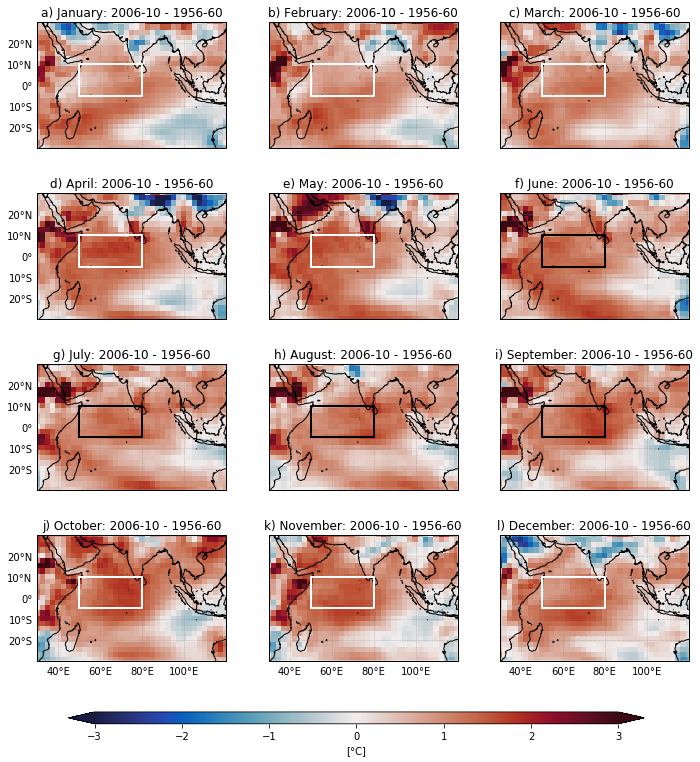

In [7]:
fignum = '06_34'

AT = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lon=slice(30, 120), lat=slice(30, -30))

air2000s = AT.sel(time=slice('2006-01-01', '2010-12-31')).groupby("time.month").mean('time')
air1950s = AT.sel(time=slice('1956-01-01', '1960-12-31')).groupby("time.month").mean('time')

air = air2000s - air1950s

projection = cartopy.crs.PlateCarree(central_longitude=75)
fig = plt.figure(figsize=(10, 11), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        i = row*3 + col
        a = air.isel(month=i).plot(cmap=cmo.balance, vmin=-3, vmax=3,
                   transform=cartopy.crs.PlateCarree(), 
                   ax=ai, add_colorbar=False, rasterized=True)
        ai.set_title('%s) %s: 2006-10 - 1956-60' % (chr(ord('a') + i), datetime.date(1900, i+1, 1).strftime('%B')))
        ai.set_extent([30, 120, -30, 30], crs=cartopy.crs.PlateCarree())
        color = 'k' if (row == 2 or (row ==1 and col == 2)) else 'w'
        ai.plot([50, 80, 80, 50, 50], [-5, -5, 10, 10, -5], color, linewidth=2, transform=cartopy.crs.PlateCarree())

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([40, 60, 80, 100, 120])
        if row == 3:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym, use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

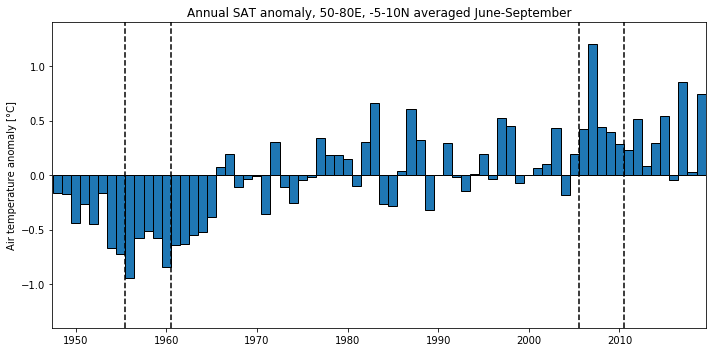

In [8]:
fignum = '06_35'

AT = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lon=slice(50, 80), lat=slice(10, -5)).mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))
junsept = [True if ((i%12 > 4) and (i%12 < 9)) else False for i in range(len(AT.time.values))]
AT = AT.where(junsept)
AT = AT.groupby("time.year").mean('time')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(AT.year.values, (AT-AT.mean('year')).values, width=1, linewidth=1, edgecolor='k')
ax.vlines([1955.5, 1960.5, 2005.5, 2010.5], -1.4, 1.4, linestyle='--')
ax.set_xlim(AT.year.values[0]-0.55, AT.year.values[-1]+0.5)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('Air temperature anomaly [%sC]' %degsym)
ax.set_title('Annual SAT anomaly, 50-80E, -5-10N averaged June-September')
plt.tight_layout()
savefig(fignum)

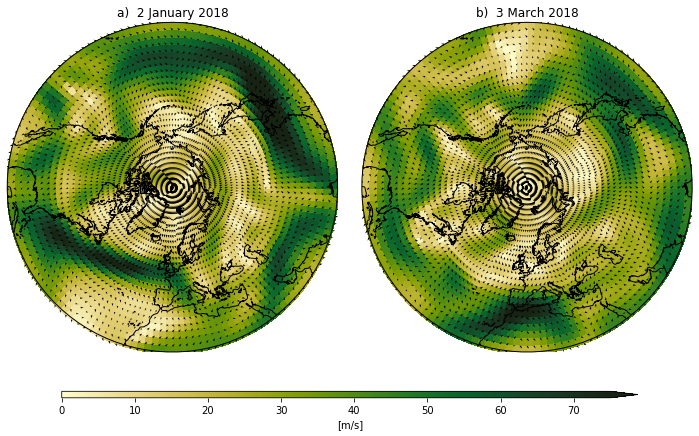

In [9]:
fignum = '07_14'

U = xr.open_dataset(datadir+'NCEP/uwnd.2018.nc').uwnd.sel(level=250).sel(lat=slice(90, 20))
V = xr.open_dataset(datadir+'NCEP/vwnd.2018.nc').vwnd.sel(level=250).sel(lat=slice(90, 20))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.NorthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['2018-01-02', '2018-03-03']
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')
    a = ai.pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                      cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=75,
                      cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
              transform=cartopy.crs.PlateCarree())
    ai.set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), spd.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

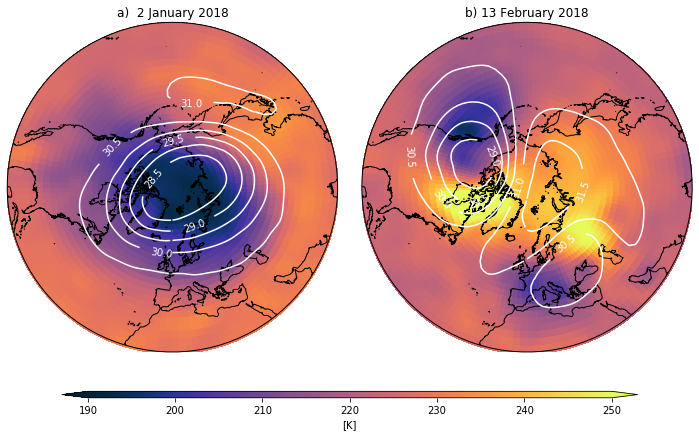

In [10]:
fignum = '07_15'

A = xr.open_dataset(datadir+'NCEP/air.2018.nc').air.sel(level=10).sel(lat=slice(90, 20))
H = xr.open_dataset(datadir+'NCEP/hgt.2018.nc').hgt.sel(level=10).sel(lat=slice(90, 20))

projection = cartopy.crs.NorthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['2018-01-02', '2018-02-13']
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(A.lon), A.lat, 
                      cartopy.util.add_cyclic_point(A.sel(time=time[i])), vmin=190, vmax=250,
                      cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    CS = ai.contour(H.lon, H.lat, H.sel(time=time[i])/1000., 
                    levels=np.arange(28.5, 32, 0.5), colors='w', transform=cartopy.crs.PlateCarree())
    ai.clabel(CS, inline=1, fontsize=10, fmt='%1.1f')
    ai.set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), A.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[K]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

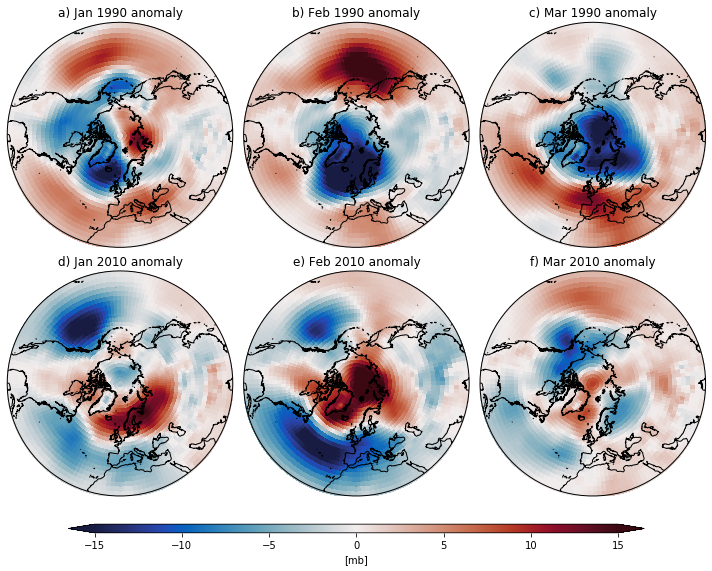

In [11]:
fignum = '07_16'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=slice(90, 20))
climatology = P.groupby("time.month").mean("time")

projection = cartopy.crs.NorthPolarStereo()
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[5, 5, 1]) 

for j, month in enumerate([1, 2, 3]):
    for i, yr in enumerate([1990, 2010]):
        ai = fig.add_subplot(gs[i, j], projection=projection)

        ai.coastlines(resolution='50m')
        anom = P.sel(time='%d-%d-01' %(yr, month)) - climatology.sel(month=month)
        a = ai.pcolormesh(cartopy.util.add_cyclic_point(anom.lon), anom.lat, 
                          cartopy.util.add_cyclic_point(anom), vmin=-15, vmax=15,
                          cmap=cmo.balance, transform=cartopy.crs.PlateCarree(), rasterized=True)

        ai.set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ai.set_boundary(circle, transform=ai.transAxes)
        ai.set_title('%s) %s anomaly' % (chr(ord('a') + i*3+j), anom.time.dt.strftime('%b %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[mb]')
fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

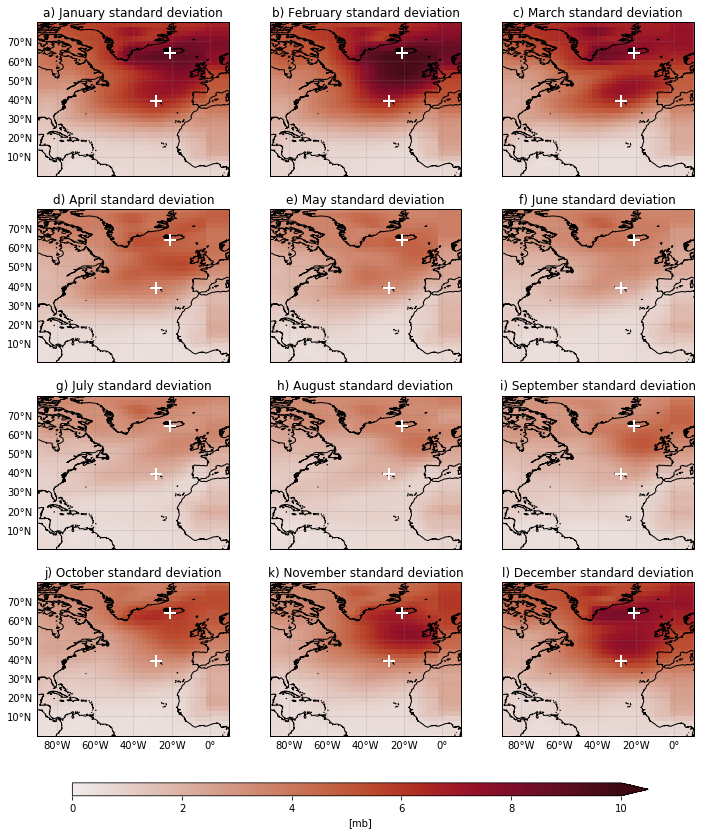

In [12]:
fignum = '07_17'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=slice(80, 0))
P = P.isel(lon=(P.lon >= 270) | (P.lon <= 10))

projection = cartopy.crs.PlateCarree(central_longitude=-40)
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        i = row*3 + col
        anom = P.where(P.time.dt.month==i+1, drop=True)
        a = ai.pcolormesh(anom.lon, anom.lat, anom.std('time'), vmin=0, vmax=10,
                          cmap=cmo.amp, transform=cartopy.crs.PlateCarree(), rasterized=True)

        ai.plot([-21, -28], [64, 39], 'w+', markersize=12, markeredgewidth=2, transform=cartopy.crs.PlateCarree())
        ai.set_extent([-90, 10, 0, 80], cartopy.crs.PlateCarree())
        ai.set_title('%s) %s standard deviation' % (chr(ord('a') + i), anom.time.dt.strftime('%B').values[0]))

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
        if row == 3:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[mb]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

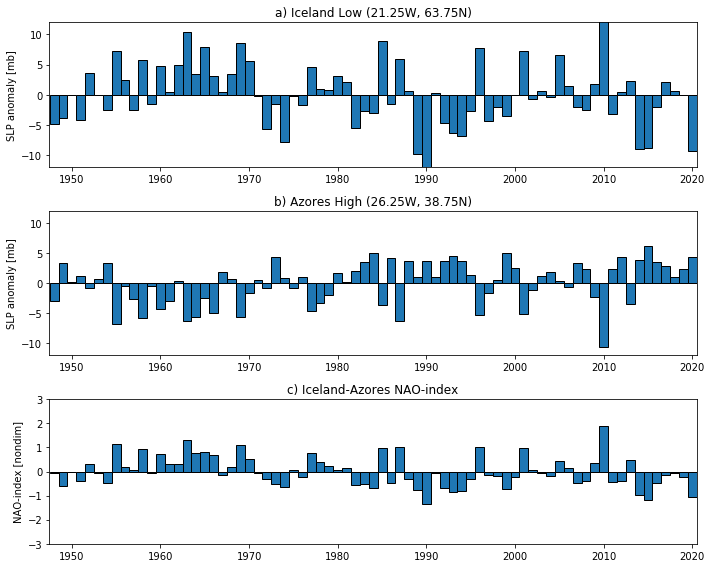

In [13]:
fignum = '07_18'

PR = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=63.75, lon=360-21.25, method='nearest')
decmar = [True if ((i%12 == 11) or (i%12 < 3)) else False for i in range(len(PR.time.values))]
PR = PR.where(decmar)
PR = PR.groupby("time.year").mean('time')
PR = PR - PR.mean('year')

PA = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=38.75, lon=360-26.25, method='nearest')
PA = PA.where(decmar)
PA = PA.groupby("time.year").mean('time')
PA = PA - PA.mean('year')

PD = PR / np.max(np.abs(PR)) - PA / np.max(np.abs(PA))
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

for i, P in enumerate([PR, PA, PD]):
    ax[i].bar(P.year.values, P.values, width=1, linewidth=1, edgecolor='k')
    ax[i].set_xlim(P.year.values[0]-0.55, P.year.values[-1]+0.5)
    ylim = 12 if i < 2 else 3
    ax[i].set_ylim(-ylim, ylim)
    if i < 2:
        ax[i].set_ylabel('SLP anomaly [mb]')
    else:
        ax[i].set_ylabel('NAO-index [nondim]')
ax[0].set_title('a) Iceland Low (21.25W, 63.75N)')
ax[1].set_title('b) Azores High (26.25W, 38.75N)')
ax[2].set_title('c) Iceland-Azores NAO-index')

plt.tight_layout()
savefig(fignum)

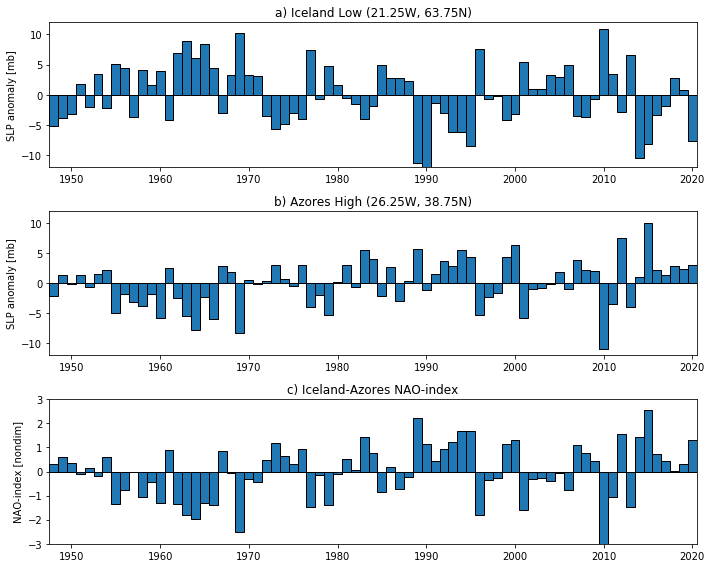

In [14]:

fignum = '07_18'

PR = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=63.75, lon=360-21.25, method='nearest')

PA = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=38.75, lon=360-26.25, method='nearest')

fig, ax = plt.subplots(3, 1, figsize=(10, 8))

slp = np.nan*np.zeros((2021-1948, 4, 2))
for ai, P in enumerate([PR, PA]):    
    for i in range(len(P)):
        y = P.time[i].dt.year.values - 1948
        if y < 73:
            if P.time[i].dt.month == 12:
                slp[y+1, 0, ai] = P[i].values
            elif P.time[i].dt.month < 4:
                slp[y, P.time[i].dt.month.values, ai] = P[i].values
    mn = np.nanmean(slp[:, :, ai], axis=0) 
    for y in range(slp.shape[0]):
        slp[y, :, ai] = slp[y, :, ai] - mn

    ax[ai].bar(np.arange(1948, 2021), np.nanmean(slp[:, :, ai], axis=1), width=1, linewidth=1, edgecolor='k')
    ax[ai].set_xlim([1947.5, 2020.5])
    ax[ai].set_ylim(-12, 12)
    ax[ai].set_ylabel('SLP anomaly [mb]')
    st = np.nanstd(slp[:, :, ai], axis=0)
    for y in range(slp.shape[0]):
        slp[y, :, ai] = slp[y, :, ai] /st

nao = slp[:, :, 1] - slp[:, :, 0]
ax[2].bar(np.arange(1948, 2021), np.nanmean(nao, axis=1), width=1, linewidth=1, edgecolor='k')
ax[2].set_xlim([1947.5, 2020.5])
ax[2].set_ylim(-3, 3)
ax[2].set_ylabel('NAO-index [nondim]')
ax[0].set_title('a) Iceland Low (21.25W, 63.75N)')
ax[1].set_title('b) Azores High (26.25W, 38.75N)')
ax[2].set_title('c) Iceland-Azores NAO-index')

plt.tight_layout()
savefig(fignum)

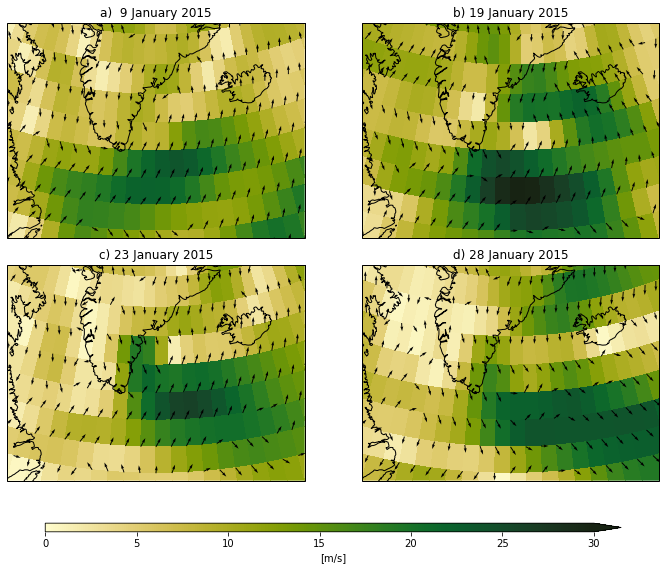

In [15]:
fignum = '07_19'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.2015.nc').uwnd.sel(lat=slice(75, 50), lon=slice(280, 365))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.2015.nc').vwnd.sel(lat=slice(75, 50), lon=slice(280, 365))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.LambertConformal(cutoff=50, central_longitude=322.5)
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = gridspec.GridSpec(3, 2, height_ratios=[4, 4, 1]) 

time = np.array([['2015-01-09', '2015-01-19'], ['2015-01-23', '2015-01-28']])
for col in range(2):
    for row in range(2):
        ai = fig.add_subplot(gs[col, row], projection=projection)
        ai.coastlines(resolution='50m')

        a = ai.pcolormesh(spd.lon, spd.lat, spd.sel(time=time[col, row]), vmin=0, vmax=30,
                             cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
        ai.quiver(X, Y, U.sel(time=time[col, row]).values, V.sel(time=time[col, row]).values,
                     transform=cartopy.crs.PlateCarree())
        ai.set_title('%s) %s' % (chr(ord('a') + row+col*2), spd.sel(time=time[col, row]).time.dt.strftime('%e %B %Y').values))
        ai.set_extent([300, 345, 35, 70], crs=cartopy.crs.PlateCarree())

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

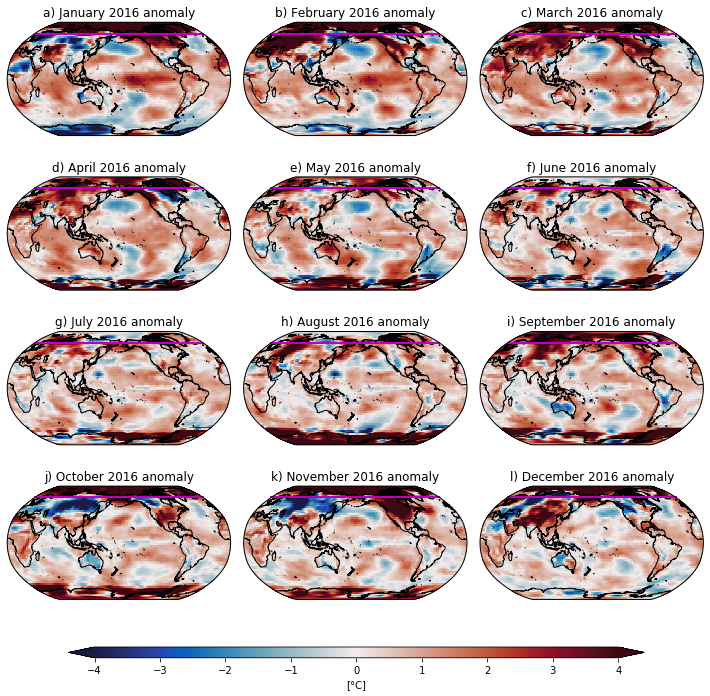

In [16]:
fignum = '07_36'

P = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air
climatology = P.groupby("time.month").mean("time")
anomalies = P.groupby("time.month") - climatology

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        i = col+row*3
        ai.coastlines(resolution='50m')
        p = anomalies.sel(time='2016-%.2d-01' % (i+1))
        a = p.plot(cmap=cmo.balance, vmin=-4, vmax=4,
                   transform=cartopy.crs.PlateCarree(), 
                   ax=ai, add_colorbar=False, rasterized=True)
        ai.plot([0, 360], [66, 66], transform=cartopy.crs.PlateCarree(), color='m', linewidth=2)
        ai.set_title('%s) %s anomaly' % (chr(ord('a') + i), p.time.dt.strftime('%B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' % degsym)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

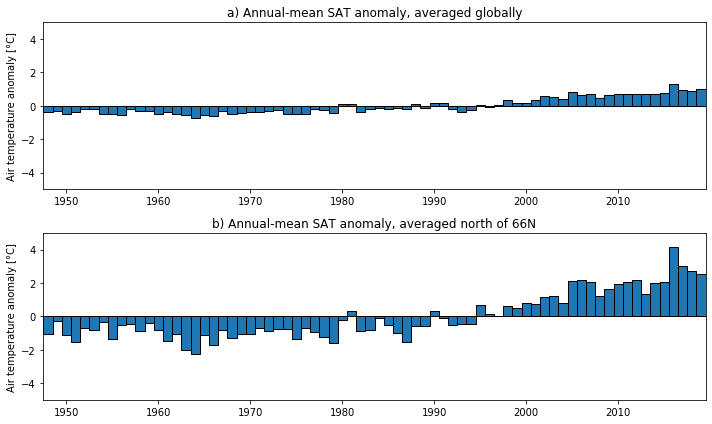

In [17]:
fignum = '07_37'

TG = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))
TA = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lat=slice(90, 66)).mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, T in enumerate([TG, TA]):
    T = T.groupby("time.year").mean('time')
    ax[i].bar(T.year.values, (T - T.mean('year')).values, width=1, linewidth=1, edgecolor='k')
    ax[i].set_xlim(T.year.values[0]-0.55, T.year.values[-1]+0.5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_ylabel('Air temperature anomaly [%sC]' %degsym)
ax[0].set_title('a) Annual-mean SAT anomaly, averaged globally')
ax[1].set_title('b) Annual-mean SAT anomaly, averaged north of 66N')

plt.tight_layout()
savefig(fignum)

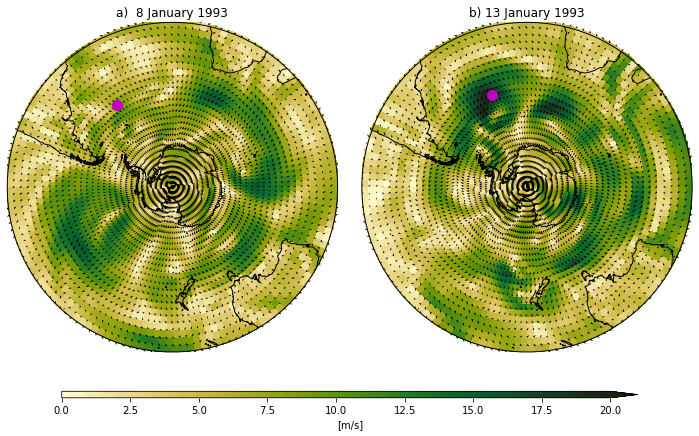

In [18]:
fignum = '08_12'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.1993.nc').uwnd.sel(lat=slice(-20, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.1993.nc').vwnd.sel(lat=slice(-20, -90))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['1993-01-08', '1993-01-13']
discovery_loc = [(-34, -45), (-21, -45)]
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                      cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=20,
                      cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ai.plot(discovery_loc[i][0], discovery_loc[i][1], 'mo', markersize=10, transform=cartopy.crs.PlateCarree())
    ai.set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), spd.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

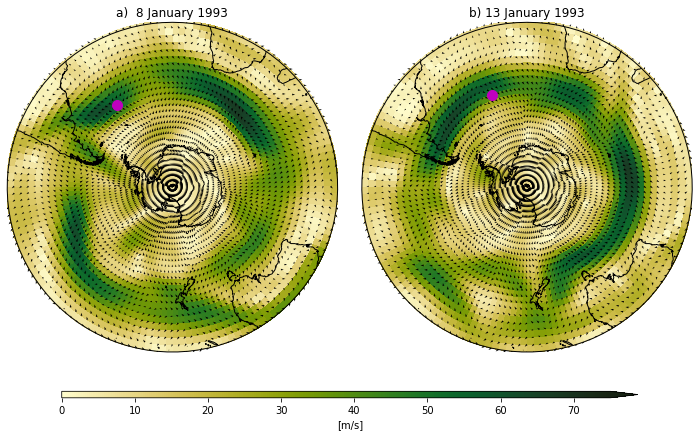

In [19]:
fignum = '08_13'

U = xr.open_dataset(datadir+'NCEP/uwnd.1993.nc').uwnd.sel(level=250, lat=slice(-20, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.1993.nc').vwnd.sel(level=250, lat=slice(-20, -90))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['1993-01-08', '1993-01-13']
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                      cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=75,
                      cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
              transform=cartopy.crs.PlateCarree())
    ai.plot(discovery_loc[i][0], discovery_loc[i][1], 'mo', markersize=10, transform=cartopy.crs.PlateCarree())
    ai.set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), spd.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

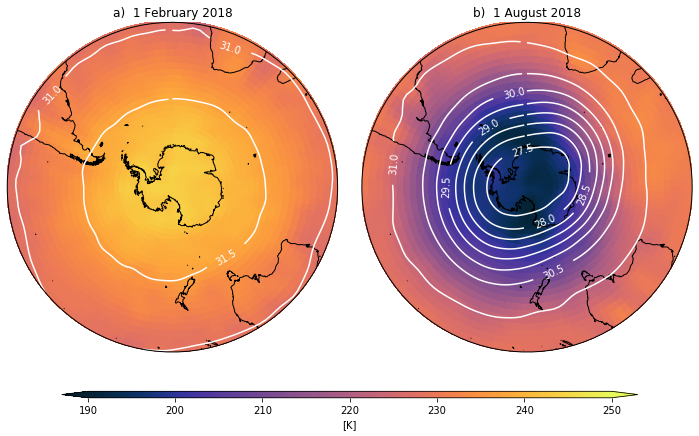

In [20]:
fignum = '08_14'

A = xr.open_dataset(datadir+'NCEP/air.2018.nc').air.sel(level=10).sel(lat=slice(-20, -90))
H = xr.open_dataset(datadir+'NCEP/hgt.2018.nc').hgt.sel(level=10).sel(lat=slice(-20, -90))

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['2018-02-01', '2018-08-01']
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(A.lon), A.lat, 
                      cartopy.util.add_cyclic_point(A.sel(time=time[i])), vmin=190, vmax=250,
                      cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    CS = ai.contour(H.lon, H.lat, H.sel(time=time[i])/1000., 
                    levels=np.arange(27, 32, 0.5), colors='w', transform=cartopy.crs.PlateCarree())
    ai.clabel(CS, inline=1, fontsize=10, fmt='%1.1f')
    ai.set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), A.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[K]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

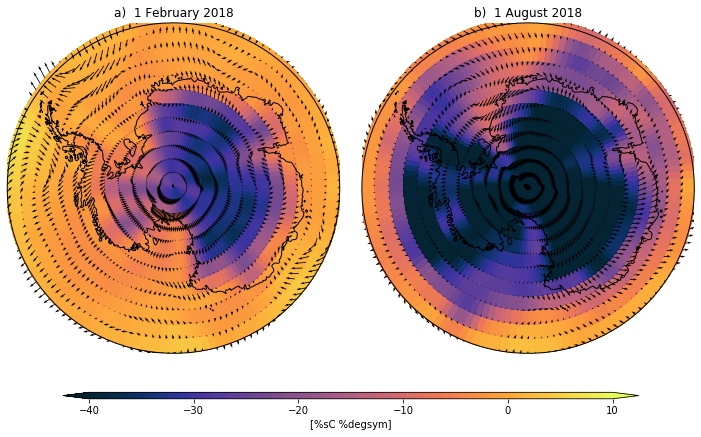

In [21]:
fignum = '08_15'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.2018.nc').uwnd.sel(lat=slice(-60, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.2018.nc').vwnd.sel(lat=slice(-60, -90))
T = xr.open_dataset(datadir+'NCEP/air.sig995.2018.nc').air.sel(lat=slice(-60, -90))
X, Y = np.meshgrid(U.lon, U.lat)

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

time = ['2018-02-01', '2018-08-01']
for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, 
                      cartopy.util.add_cyclic_point(T.sel(time=time[i]))-273.15, vmin=-40, vmax=10,
                      cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
              transform=cartopy.crs.PlateCarree())
    ai.set_extent([-180, 180, -90, -60], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) %s' %(chr(ord('a') + i), T.sel(time=time[i]).time.dt.strftime('%e %B %Y').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC %degsym]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

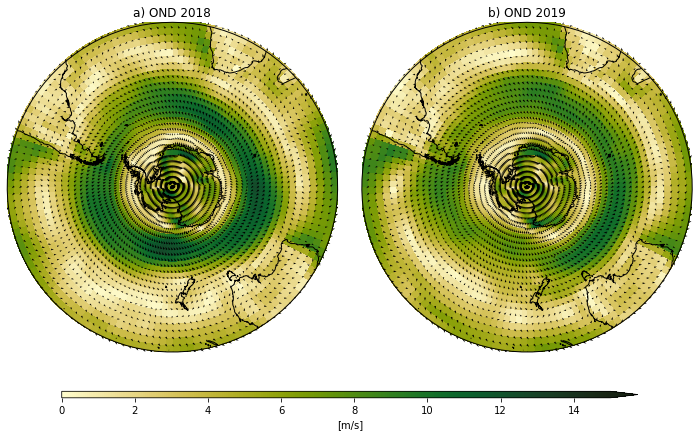

In [22]:
fignum = '08_17'

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

for i, yr in enumerate([2018, 2019]):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')

    U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.%d.nc' % yr).uwnd.sel(lat=slice(-20, -90)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.%d.nc' % yr).vwnd.sel(lat=slice(-20, -90)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    spd = np.hypot(U, V)
    U = U / np.sqrt(U**2 + V**2);
    V = V / np.sqrt(U**2 + V**2);
    X, Y = np.meshgrid(spd.lon, spd.lat)

    a = ai.pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                      cartopy.util.add_cyclic_point(spd), vmin=0, vmax=15,
                      cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.values, V.values,
              transform=cartopy.crs.PlateCarree())
    ai.set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)
    ai.set_title('%s) OND %d' % (chr(ord('a') + i), yr))
    
cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

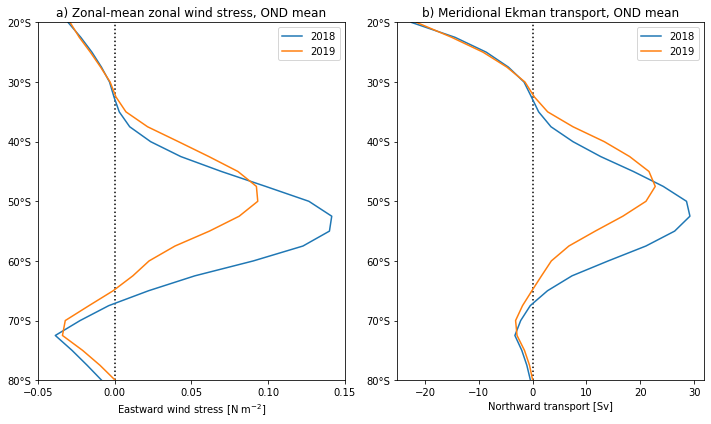

In [23]:
fignum = '08_28'

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])


for i, yr in enumerate([2018, 2019]):
    U = xr.open_dataset(datadir+'NCEP/uwnd.mon.mean.nc').uwnd.sel(lat=slice(-20, -80)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    V = xr.open_dataset(datadir+'NCEP/vwnd.mon.mean.nc').vwnd.sel(lat=slice(-20, -80)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    spd = np.hypot(U, V)
    rho_air = 1.3
    Cd = 1e-3*(0.61 + (0.063*spd))
    taux = rho_air * Cd * U * spd
    Ve = np.nan * np.ones(taux.shape[0])
    for j in range(Ve.shape[0]):
        circumf = 360 * 1852 * 60 * np.cos(taux.lat[j]/180*np.pi)
        Ve[j] = -taux.mean('lon')[j] / (1020 * gsw.f(taux.lat[j])) * circumf /1e6

    ax0.plot(taux.mean('lon'), taux.lat, 'C0%d' % i, label=yr)
    ax0.set_xlim([-0.05, 0.15])
    ax0.set_title('a) Zonal-mean zonal wind stress, OND mean')
    ax0.set_xlabel('Eastward wind stress [N m$^{-2}$]')
    ax0.xaxis.set_major_locator(mticker.MultipleLocator(0.05))

    ax1.plot(Ve, taux.lat, 'C0%d' % i, label=yr)
    ax1.set_title('b) Meridional Ekman transport, OND mean')
    ax1.set_xlabel('Northward transport [Sv]')

for ai in [ax0, ax1]:
    ai.set_ylim([-80, -20])
    ai.vlines(0, -80, -20, 'k', linestyle=':')
    ai.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    ai.legend()
    
plt.tight_layout()
savefig(fignum)

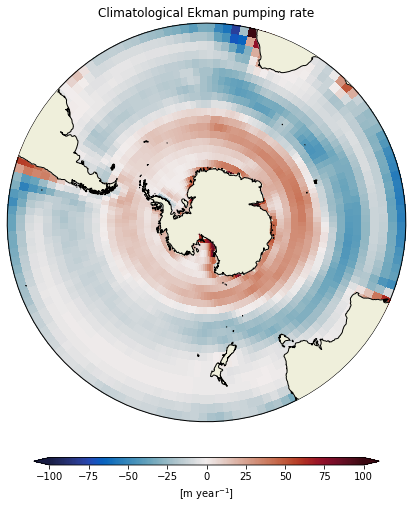

In [24]:
fignum = '08_36'

U = xr.open_dataset(datadir+'NCEP/uwnd.mon.mean.nc').uwnd.mean('time').sel(lat=slice(-21, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.mon.mean.nc').vwnd.mean('time').sel(lat=slice(-21, -90))
spd = np.hypot(U, V)
rho_air = 1.3
Cd = 1e-3*(0.61 + (0.063*spd))
taux = rho_air * Cd * U * spd
tauy = rho_air * Cd * V * spd

We = np.nan * np.ones(taux.shape)
for j in range(1, We.shape[0]-1):
    if abs(taux.lat[j]) > 5:
        for i in range(We.shape[1]):
            ip1 = i+1 if i < We.shape[1]-1 else 0
            im1 = i-1 if i >0 else We.shape[1]-1
            dtxdy = (taux[j+1, i] - taux[j-1, i]) / ((taux.lat[j+1] - taux.lat[j-1]) * 1852 * 60)
            dtydx = (tauy[j, ip1] - tauy[j, im1]) / ((taux.lon[ip1] - taux.lon[im1]) * 1852 * 60 * np.cos(taux.lat[j]/180*np.pi))
            We[j, i] = 1/(1020 * gsw.f(taux.lat[j])) * (dtydx - dtxdy) * 86400*365

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(resolution='50m', zorder=11)
ax.add_feature(cartopy.feature.LAND, zorder=10)

a = ax.pcolormesh(cartopy.util.add_cyclic_point(taux.lon), cartopy.util.add_cyclic_point(taux.lat), 
                  cartopy.util.add_cyclic_point(We), cmap=cmo.balance, vmin=-100, vmax=100,
                  transform=cartopy.crs.PlateCarree(), rasterized=True)

ax.set_extent([-180, 180, -90, -25], cartopy.crs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.title('Climatological Ekman pumping rate')
cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m year$^{-1}$]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

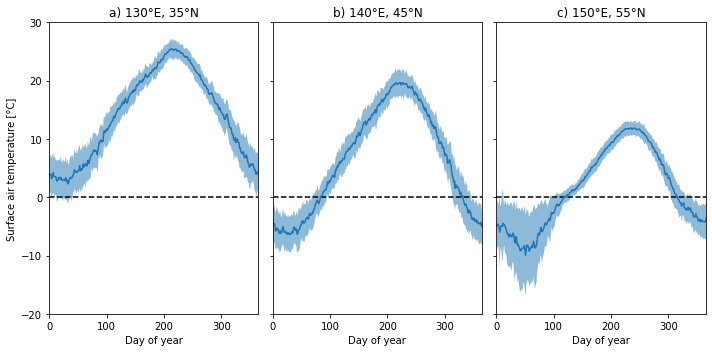

In [25]:
fignum = '09_30'

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

lats = [35, 45, 55]
lons = [130, 140, 150]

for i in range(3):
    T = xr.open_mfdataset(datadir+'NCEP/air.sig995.*', combine='by_coords').air.sel(lat=lats[i], lon=lons[i], method='nearest')
    T = T.sel(time=slice('1965-01-01', '2015-12-31')) - 273.15
    mean = T.groupby('time.dayofyear').mean('time')
    std = T.groupby("time.dayofyear").std('time')

    ax[i].plot([0, 365], [0, 0], 'k--')
    ax[i].plot(mean.dayofyear, mean)
    ax[i].fill_between(mean.dayofyear, mean-std, mean+std, alpha=0.5)
    ax[i].set_xlabel('Day of year')
    if i == 0:
        ax[i].set_ylabel('Surface air temperature [%sC]' % degsym)
    else:
        ax[i].set_yticklabels([])
    ax[i].set_xlim([0, 365])
    ax[i].set_ylim([-20, 30])
    ax[i].set_title('%s) %d%sE, %d%sN' % (chr(ord('a') + i), lons[i], degsym, lats[i], degsym))

plt.tight_layout()
savefig(fignum)

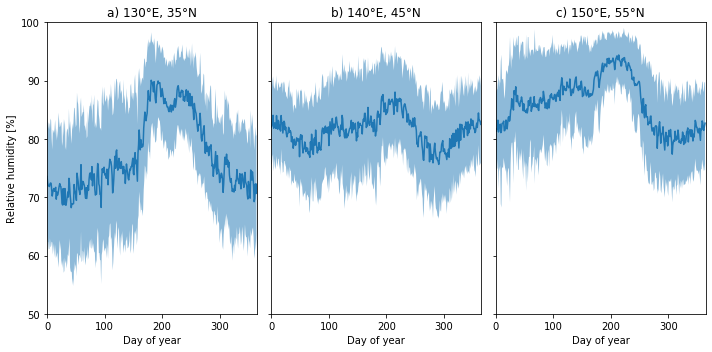

In [26]:
fignum = '09_31'

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

expname = ['JapaSSea', 'JapaNSea', 'OkhotSea']
lats = [35, 45, 55]
lons = [130, 140, 150]
for i in range(3):
    files = sorted(glob(datadir+'NCEP/Preprocessed/%s/%s*' % (expname[i], expname[i])))
    relhumid = np.nan*np.zeros((366, len(files)))
    for f, file in enumerate(files):
        data = np.loadtxt(file)
        relhumid[:data.shape[0], f] = data[:, 6]

    mean = np.mean(relhumid, axis=1)
    std = np.std(relhumid, axis=1)
    ax[i].plot([0, 365], [0, 0], 'k--')
    ax[i].plot(np.arange(366), mean)
    ax[i].fill_between(np.arange(366), mean-std, mean+std, alpha=0.5)
    ax[i].set_xlabel('Day of year')
    if i == 0:
        ax[i].set_ylabel('Relative humidity [%]')
    else:
        ax[i].set_yticklabels([])
    ax[i].set_xlim([0, 365])
    ax[i].set_ylim([50, 100])
    ax[i].set_title('%s) %d%sE, %d%sN' % (chr(ord('a') + i), lons[i], degsym, lats[i], degsym))

plt.tight_layout()
savefig(fignum)

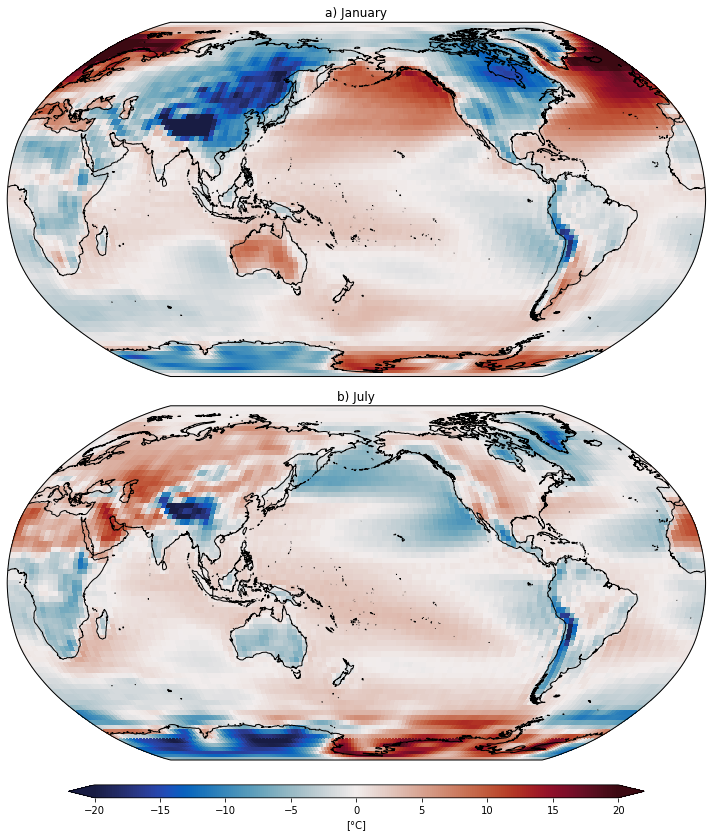

In [27]:
fignum = '11_22'

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
hr = 6
gs = gridspec.GridSpec(3, 1, height_ratios=[hr, hr, 1]) 

for i, month in enumerate([1, 7]):
    ai = fig.add_subplot(gs[i], projection=projection)
    ai.coastlines(resolution='50m')
    T = xr.open_mfdataset(datadir+'NCEP/air.sig995*', combine='by_coords').air
    temp = T.where(T.time.dt.month==month, drop=True)
    tempanom = temp.mean('time') - temp.mean('time').mean('lon')
    a = tempanom.plot(cmap=cmo.balance, vmin=-20, vmax=20,
                      transform=cartopy.crs.PlateCarree(),
                      ax=ai, add_colorbar=False, rasterized=True)
    ai.set_title('%s) %s' % (chr(ord('a') + i), temp.time[0].dt.strftime('%B').values))

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym, use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)